In [1]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2  import preprocess_input
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy.ndimage import rotate
import gc
# import mlflow

# mlflow.set_tracking_uri("http://localhost:5000")
# mlflow.tensorflow.autolog()
# mlflow.set_experiment('rotation_network')

# GPU memory configurtion - must be done first!
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Clear any existing models/sessions
tf.keras.backend.clear_session()
gc.collect()

0

### download and generate data (Cifar10 is used for training and test)

In [12]:
# load cifar10 dataset
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    return x_train, y_train, x_test, y_test

# data generator for image pairs (original, rotated)
class RotationPairGenerator(tf.keras.utils.Sequence):
    def __init__(self, images, batch_size=32, rotation_angles=None, image_size=(96, 96), shuffle=True):
        self.images = images
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        
        # Define rotation angles in degrees (every 15 degrees clockwise)
        if rotation_angles is None:
            self.rotation_angles = np.arange(0, 360, 15)
        else:
            self.rotation_angles = rotation_angles
            
        self.indices = np.arange(len(self.images))
        if self.shuffle:
            np.random.shuffle(self.indices)


    def __len__(self):
        return len(self.images) // self.batch_size

    def __getitem__(self, idx):
        batch_indices = self.indices[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_images = self.images[batch_indices]

        image_origin_batch = []
        image_rotated_batch = []
        angle_batch = []

        for img in batch_images:
            img_padded = tf.image.resize_with_pad(img, self.image_size[0], self.image_size[1])

            
            # select a random angle
            angle = np.random.choice(self.rotation_angles)
            normalized_angle = angle / 360.0

            # Create rotated version (negative angle because scipy.ndimage.rotate rotates counterclockwise)
            img_rotated = rotate(img, -angle, reshape=False)
            img_rotated_resized = tf.image.resize_with_pad(img_rotated, self.image_size[0], self.image_size[1]) # same preprocessing as original image
            


                   
            # Alternative: Convert to sine and cosine components for circular representation
            # angle_rad = math.radians(angle)
            # sin_angle = math.sin(angle_rad)
            # cos_angle = math.cos(angle_rad)
            
            image_origin_batch.append(img_padded)
            image_rotated_batch.append(img_rotated_resized)
            angle_batch.append(normalized_angle)
        
        #preprocess for MobileNetV2
        image_origin_batch = np.array(image_origin_batch)
        image_rotated_batch = np.array(image_rotated_batch)

        # Apply MobileNetV2 preprocessing to both batches
        image_origin_batch = preprocess_input(image_origin_batch)
        image_rotated_batch = preprocess_input(image_rotated_batch)

        return [image_origin_batch, image_rotated_batch], np.array(angle_batch)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [3]:
# Create data augmentation pipeline
def create_augmentation_layer():
    return tf.keras.Sequential([
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
    ])

### Model Creation and Training

In [ ]:
# Create Siamese Network model
def create_siamese_model(input_shape=(96, 96, 3)):
    # Input layers
    input_image1 = layers.Input(shape=input_shape)
    input_image2 = layers.Input(shape=input_shape)
    
    # Base model with weights, exclude top layer
    base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    base_model.summary()
    # Freeze early layers
    for layer in base_model.layers[:100]:
        layer.trainable = False
    
    # Feature extraction
    features1 = base_model(input_image1)
    features2 = base_model(input_image2)
    
    # Flatten features
    flat1 = layers.Flatten()(features1)
    flat2 = layers.Flatten()(features2)
    
    # Concatenate features from the two input images
    concat = layers.Concatenate()([flat1, flat2])
    
    # Dense layers for prediction
    x = layers.Dense(512, activation='relu')(concat)
    x = layers.Dense(256, activation='relu')(x)
    
    # Output layer - regression head. output is the normalized angle 0 to 1 
    output = layers.Dense(1, activation='linear')(x)
    
    # Create model
    model = Model(inputs=[input_image1, input_image2], outputs=output)
    
    return model

In [5]:
# Custom loss function for circular data (optional)
def angular_loss(y_true, y_pred):
    # Convert normalized angles (0-1) back to radians (0-2π)
    y_true_rad = y_true * 2 * np.pi
    y_pred_rad = y_pred * 2 * np.pi
    
    # Calculate the angular difference considering the circular nature
    diff = tf.abs(tf.math.atan2(tf.math.sin(y_true_rad - y_pred_rad), tf.math.cos(y_true_rad - y_pred_rad)))
    
    return tf.reduce_mean(diff)

In [6]:
# Training function
def train_siamese_model():
    # Load data
    x_train, y_train, x_test, y_test = load_data()
    
    # Create data generators
    train_gen = RotationPairGenerator(
        x_train, 
        batch_size=32, 
        image_size=(96, 96),
        shuffle=True
    )
    
    val_gen = RotationPairGenerator(
        x_test, 
        batch_size=32, 
        image_size=(96, 96),
        shuffle=False
    )
    
   
    # Create model
    model = create_siamese_model()

    # Compile model
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        #TODO: try angular_loss
        loss='mse',  
        metrics=['mae']
    )
    
    # Callbacks
    callbacks = [
        tf.keras.callbacks.ModelCheckpoint(
            'siamese_rotation_model.h5',
            save_best_only=True,
            monitor='val_loss'
        ),
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=10,
            restore_best_weights=True
        ),
        tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            factor=0.5,
            patience=5
        )
    ]
    
    # Train model
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=50,
        callbacks=callbacks
    )
    
     
    
    # Log model with signature
    mlflow.tensorflow.log_model(
        model,
        "model"
    )
    
    return model, history

In [7]:
# Main execution
if __name__ == "__main__":
    model, history = train_siamese_model()
    
    
    

2025-03-10 14:39:15.822902: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-10 14:39:15.823034: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-03-10 14:39:15.823086: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Epoch 1/50


2025-03-10 14:39:20.284173: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8907
2025-03-10 14:39:20.346949: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-03-10 14:39:21.631195: I external/local_xla/xla/service/service.cc:168] XLA service 0x599fb1be7fc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-03-10 14:39:21.631211: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2025-03-10 14:39:21.634481: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1741617561.673860   95868 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1562/1562 [==============================] - ETA: 0s - loss: 0.1133 - mae: 0.2467

/home/hamed/code/hamed/rotation_project/.venv/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1562/1562 [==============================] - 249s 155ms/step - loss: 0.1133 - mae: 0.2467 - val_loss: 0.0645 - val_mae: 0.2063 - lr: 1.0000e-04
Epoch 2/50
1562/1562 [==============================] - 241s 154ms/step - loss: 0.0462 - mae: 0.1700 - val_loss: 0.0409 - val_mae: 0.1568 - lr: 1.0000e-04
Epoch 3/50
1562/1562 [==============================] - 239s 153ms/step - loss: 0.0272 - mae: 0.1246 - val_loss: 0.0311 - val_mae: 0.1316 - lr: 1.0000e-04
Epoch 4/50
1562/1562 [==============================] - 236s 151ms/step - loss: 0.0175 - mae: 0.0974 - val_loss: 0.0189 - val_mae: 0.0992 - lr: 1.0000e-04
Epoch 5/50
1562/1562 [==============================] - 243s 156ms/step - loss: 0.0126 - mae: 0.0810 - val_loss: 0.0159 - val_mae: 0.0919 - lr: 1.0000e-04
Epoch 6/50
1562/1562 [==============================] - 234s 150ms/step - loss: 0.0095 - mae: 0.0696 - val_loss: 0.0112 - val_mae: 0.0728 - lr: 1.0000e-04
Epoch 7/50
1562/1562 [==============================] - 237s 152ms/step - loss: 0

2025/03/10 17:58:01 WARNING mlflow.tensorflow: Failed to infer model signature: could not sample data to infer model signature: unsupported operand type(s) for *: 'slice' and 'int'
2025/03/10 17:58:01 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


INFO:tensorflow:Assets written to: /tmp/tmpk_1ycahk/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpk_1ycahk/model/data/model/assets
2025/03/10 17:58:12 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/10 17:58:12 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.
2025/03/10 17:58:13 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.


🏃 View run wise-robin-261 at: http://localhost:5000/#/experiments/233083290637198557/runs/0bcf4311a5574077b24854d50a76ca2a
🧪 View experiment at: http://localhost:5000/#/experiments/233083290637198557
INFO:tensorflow:Assets written to: /tmp/tmpk0jhs6cp/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpk0jhs6cp/model/data/model/assets
2025/03/10 17:58:23 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.
2025/03/10 17:58:23 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


In [19]:
tf.__version__

'2.15.0'

### Model Performance & Error Analysis

In [2]:
# load cifar10 dataset
def load_data():
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    return x_train, y_train, x_test, y_test

def predict_and_visualize(model, test_images, num_samples=5):
    # Create random indices for test images
    indices = np.random.choice(len(test_images), num_samples, replace=False)
    original_images = test_images[indices]
    
    # Create lists to store the image pairs and angles
    img1_list = []
    img2_list = []
    angles = []
    
    # Create rotation pairs manually for visualization
    for img in original_images:
        # Resize original image and apply central cropping to remove edge artifacts
        img_resized = tf.image.resize_with_pad(img, 96, 96).numpy()
        
        # Select random rotation angle
        angle = np.random.choice(np.arange(0, 360, 15))
        
        # Create rotated version
        img_rotated = rotate(img, -angle, reshape=False)
        img_rotated_resized = tf.image.resize_with_pad(img_rotated, 96, 96).numpy()
        
        # Store original and rotated images before preprocessing
        img1_list.append(img_resized)
        img2_list.append(img_rotated_resized)
        angles.append(angle)
    
    # Preprocess for prediction
    img1_preprocessed = preprocess_input(np.array(img1_list))
    img2_preprocessed = preprocess_input(np.array(img2_list))
    
    # Make predictions using preprocessed images
    predictions = model.predict([img1_preprocessed, img2_preprocessed])
    pred_angles = predictions * 360  # Convert back to degrees
    
    # Display using original (non-preprocessed) images
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        # Display original image
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(img1_list[i].astype(np.uint8))
        plt.title('Original')
        plt.axis('off')
        
        # Display rotated image
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(img2_list[i].astype(np.uint8))
        plt.title(f'Rotated: {angles[i]:.1f}°')
        plt.axis('off')
        
        # Display rotated image with prediction
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow(img2_list[i].astype(np.uint8))
        plt.title(f'Predicted: {pred_angles[i][0]:.1f}°')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()


1/1 [==============================] - 1s 563ms/step


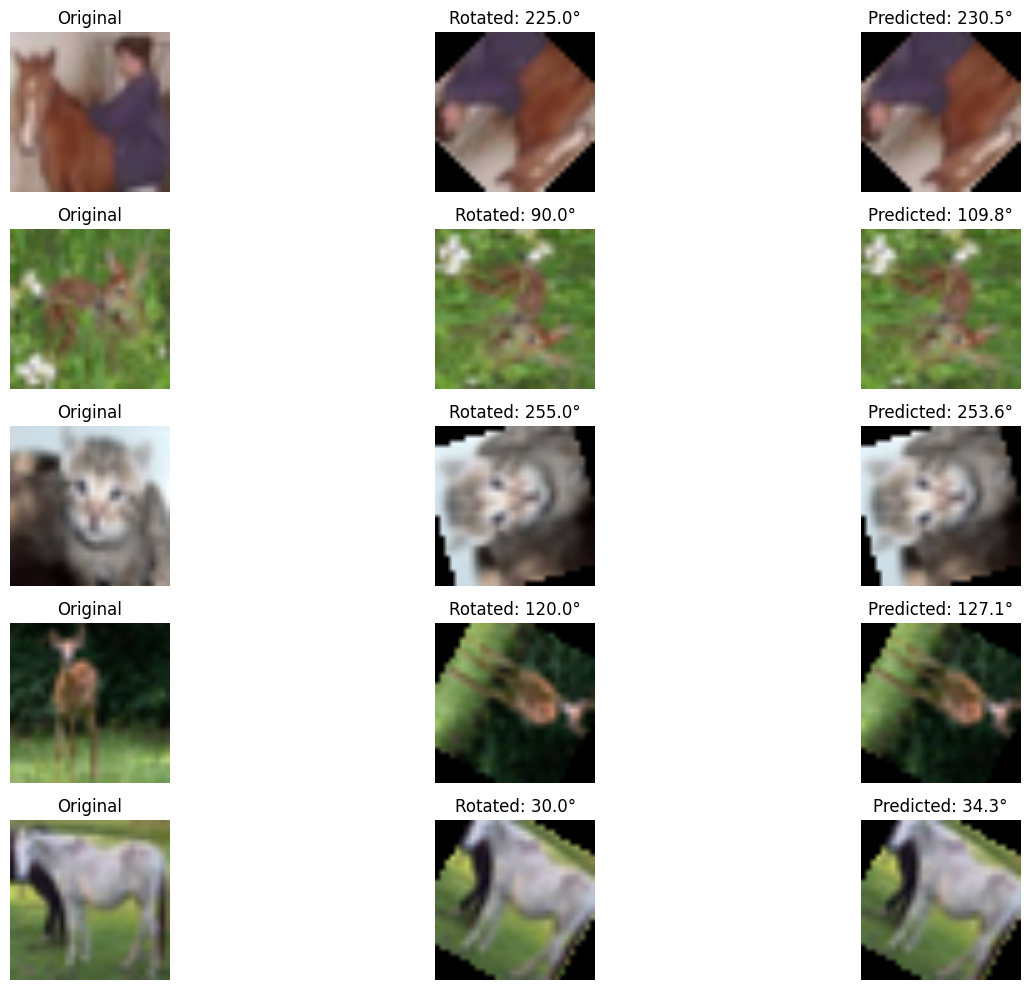

In [9]:
# load the model
# model = tf.keras.models.load_model('/home/hamed/code/hamed/rotation_project/siamese_rotation_model.h5')
# Load test data for visualization
_, _, x_test, _ = load_data()
   
# Visualize some predictions
predict_and_visualize(model, x_test)

In [28]:
def plot_training_history(history):
    """
    Plot the training and validation loss and metrics from the history object.
    
    Args:
        history: History object returned by model.fit()
    """
    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # Plot mean absolute error if available
    if 'mae' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Mean Absolute Error Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('MAE (degrees)')
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.show()

def perform_error_analysis(model, test_images, num_samples=None, angle_bins=24):
    """
    Perform comprehensive error analysis on test dataset.
    
    Args:
        model: Trained Siamese model
        test_images: Test image dataset
        num_samples: Number of test samples to evaluate
        angle_bins: Number of bins for angle distribution (default: 24 for 15-degree bins)
    """
    # Create a larger test set for statistical analysis
    # Create lists to store data
    img1_list = []
    img2_list = []
    true_angles = []
    
    
    if num_samples is None:
        indices = np.arange(len(test_images))
    else:
        indices = np.random.choice(len(test_images), min(num_samples, len(test_images)), replace=False)

    original_images = test_images[indices]

    # Generate continuous angles upfront
    continuous_angles = np.random.uniform(0, 360, size=len(original_images))

    for idx, img in enumerate(original_images):
        # Resize original image
        img_small = tf.image.resize(img, (32,32))
        img_resized = tf.image.resize_with_pad(img_small, 96, 96).numpy()
        
        # Select random rotation angle from our binned angles
        # angle = np.random.choice(angles_to_test)
        angle = continuous_angles[idx]
        
        # Create rotated version
        img_rotated = rotate(img_small, -angle, reshape=False)
        img_rotated_resized = tf.image.resize_with_pad(img_rotated, 96, 96).numpy()
        
        # Store images and angle
        img1_list.append(img_resized)
        img2_list.append(img_rotated_resized)
        true_angles.append(angle)
    
    # Preprocess for prediction
    img1_preprocessed = preprocess_input(np.array(img1_list))
    img2_preprocessed = preprocess_input(np.array(img2_list))
    
    # Make predictions
    predictions = model.predict([img1_preprocessed, img2_preprocessed])
    pred_angles = predictions.flatten() * 360  # Convert back to degrees
    
    # Calculate errors
    true_angles = np.array(true_angles)
    
    # Calculate raw errors (can be positive or negative)
    raw_errors = pred_angles - true_angles
    
    # Calculate absolute errors
    abs_errors = np.abs(raw_errors)
    
    # Account for circular nature of angles (e.g., 350 vs 10 should be 20 error, not 340°)
    circular_errors = np.minimum(abs_errors, 360 - abs_errors)
    
    # Print error statistics
    print("Error Analysis:")
    print(f"Mean Absolute Error: {np.mean(circular_errors):.2f}")
    print(f"Median Absolute Error: {np.median(circular_errors):.2f}")
    print(f"Standard Deviation of Error: {np.std(circular_errors):.2f}")
    print(f"Min Error: {np.min(circular_errors):.2f}")
    print(f"Max Error: {np.max(circular_errors):.2f}")
    print(f"Error < 15°: {100 * np.mean(circular_errors < 15):.2f}%")
    print(f"Error < 30°: {100 * np.mean(circular_errors < 30):.2f}%")
    
    # Create visualizations
    plt.figure(figsize=(18, 10))
    
    # 1. Error histogram
    plt.subplot(2, 3, 1)
    plt.hist(circular_errors, bins=20, color='skyblue', edgecolor='black')
    plt.title('Distribution of Absolute Errors')
    plt.xlabel('Error (degrees)')
    plt.ylabel('Frequency')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # 2. Error vs true angle
    plt.subplot(2, 3, 2)
    plt.scatter(true_angles, circular_errors, alpha=0.5, color='blue')
    plt.title('Error vs True Angle')
    plt.xlabel('True Angle (degrees)')
    plt.ylabel('Error (degrees)')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # 3. Predicted vs True angles
    plt.subplot(2, 3, 3)
    plt.scatter(true_angles, pred_angles, alpha=0.5, color='green')
    # Add perfect prediction line
    angle_range = np.linspace(0, 360, 100)
    plt.plot(angle_range, angle_range, 'r--', alpha=0.7)
    plt.title('Predicted vs True Angles')
    plt.xlabel('True Angle (degrees)')
    plt.ylabel('Predicted Angle (degrees)')
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # 4. Box plot of errors by angle bin
    angle_bin_edges = np.linspace(0, 360, angle_bins + 1)
    angle_bins_centers = (angle_bin_edges[:-1] + angle_bin_edges[1:]) / 2
    angle_bin_indices = np.digitize(true_angles, angle_bin_edges) - 1
    angle_bin_indices = np.clip(angle_bin_indices, 0, len(angle_bins_centers) - 1)
    
    error_by_bin = [circular_errors[angle_bin_indices == i] for i in range(len(angle_bins_centers))]
    
    plt.subplot(2, 3, 4)
    plt.boxplot(error_by_bin, labels=[f"{int(a)}" for a in angle_bins_centers])
    plt.title('Error Distribution by True Angle')
    plt.xlabel('True Angle (degrees)')
    plt.ylabel('Error (degrees)')
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.6)
    
    # 5. Confusion matrix-like visualization for angle bins
    # bin_width = 360 // angle_bins
    # true_bins = np.floor(true_angles / bin_width).astype(int) % angle_bins
    # pred_bins = np.floor(pred_angles / bin_width).astype(int) % angle_bins
    
    # confusion = np.zeros((angle_bins, angle_bins))
    # for t, p in zip(true_bins, pred_bins):
    #     confusion[t, p] += 1
    
    # # # Normalize by row
    # row_sums = confusion.sum(axis=1, keepdims=True)
    # confusion_norm = confusion / row_sums
    

    # plt.subplot(2, 3, 5)
    # plt.imshow(confusion_norm, cmap='Blues')
    # plt.colorbar(label='Proportion')
    # plt.title('Angle Bin Confusion Matrix')
    # plt.xlabel('Predicted Angle Bin')
    # plt.ylabel('True Angle Bin')
    # tick_labels = [f"{i*bin_width}°" for i in range(angle_bins)]
    # plt.xticks(range(angle_bins), tick_labels, rotation=45)
    # plt.yticks(range(angle_bins), tick_labels)
    

    angle_bins_fine = 72  # 5° bins
    bin_width_fine = 360 // angle_bins_fine
    true_bins_fine = np.floor(true_angles / bin_width_fine).astype(int) % angle_bins_fine
    pred_bins_fine = np.floor(pred_angles / bin_width_fine).astype(int) % angle_bins_fine
    
    confusion_fine = np.zeros((angle_bins_fine, angle_bins_fine))
    for t, p in zip(true_bins_fine, pred_bins_fine):
        confusion_fine[t, p] += 1

    # Show raw counts instead of normalization
    plt.subplot(2, 3, 5)
    plt.imshow(confusion_fine, cmap='Blues', aspect='auto')
    plt.colorbar(label='Count')
    plt.title('Fine-grained Angle Confusion Matrix\n(5° bins)')
    plt.xlabel('Predicted Angle Bin')
    plt.ylabel('True Angle Bin')
    tick_labels = [f"{i*bin_width_fine}°" for i in range(angle_bins)]
    plt.xticks(range(angle_bins), tick_labels, rotation=45)
    plt.yticks(range(angle_bins), tick_labels)
    
    # Add more informative tick labels
    tick_step = 6  # Show every 30°
    tick_positions = np.arange(0, angle_bins_fine, tick_step)
    tick_labels = [f"{i*bin_width_fine}°" for i in tick_positions]
    plt.xticks(tick_positions, tick_labels, rotation=45)
    plt.yticks(tick_positions, tick_labels)

    # 6. Cumulative error distribution
    plt.subplot(2, 3, 6)
    sorted_errors = np.sort(circular_errors)
    cumulative = np.arange(1, len(sorted_errors) + 1) / len(sorted_errors)
    plt.plot(sorted_errors, cumulative, 'b-')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.title('Cumulative Error Distribution')
    plt.xlabel('Error (degrees)')
    plt.ylabel('Proportion')
    
    # Add reference lines at common thresholds
    for threshold in [15, 30, 45]:
        plt.axvline(x=threshold, color='r', linestyle='--', alpha=0.3)
        idx = np.searchsorted(sorted_errors, threshold)
        if idx < len(cumulative):
            plt.text(threshold + 2, cumulative[idx], f'{cumulative[idx]*100:.1f}%', 
                     verticalalignment='center')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'true_angles': true_angles,
        'predicted_angles': pred_angles,
        'errors': circular_errors,
        'mean_error': np.mean(circular_errors),
        'median_error': np.median(circular_errors),
        'std_error': np.std(circular_errors),
        'error_by_angle': list(zip(true_angles, circular_errors))
    }

def perform_detailed_analysis(error_stats):
    """
    Perform additional analysis on the error statistics.
    """
    true_angles = error_stats['true_angles']
    pred_angles = error_stats['predicted_angles']
    circular_errors = error_stats['errors']
    
    # Analyze errors near 0/360 boundary
    boundary_mask = (true_angles > 345) | (true_angles < 15)
    boundary_errors = circular_errors[boundary_mask]
    print(f"Mean error near 0/360 boundary: {np.mean(boundary_errors):.2f}")
    
    # Analyze errors by angle regions
    angle_regions = [(0,90), (90,180), (180,270), (270,360)]
    for start, end in angle_regions:
        mask = (true_angles >= start) & (true_angles < end)
        region_errors = circular_errors[mask]
        print(f"Mean error for {start}°-{end}°: {np.mean(region_errors):.2f}")
    
    # Check for systematic bias
    raw_errors = pred_angles - true_angles
    bias = np.mean(raw_errors)
    print(f"Overall prediction bias: {bias:.2f}°")

def predict_rotation_angle(model, image1, image2, input_size=(96, 96)):
    """
    Predict the rotation angle between two images using the trained Siamese model.
    """
    # Ensure images are in float32 format
    image1 = image1.astype('float32')
    image2 = image2.astype('float32')

    # First resize to CIFAR-10 size (32x32) to match training distribution
    image1_small = tf.image.resize(image1, (32, 32))
    image2_small = tf.image.resize(image2, (32, 32))

    
    # Resize images to target size
    image1_resized = tf.image.resize_with_pad(image1_small, input_size[0], input_size[1]).numpy()
    image2_resized = tf.image.resize_with_pad(image2_small, input_size[0], input_size[1]).numpy()
    
    # Store original resized images for visualization
    image1_display = image1_resized.copy()
    image2_display = image2_resized.copy()
    
    # Expand dimensions to create batch of size 1
    image1_batch = np.expand_dims(image1_resized, axis=0)
    image2_batch = np.expand_dims(image2_resized, axis=0)
    
    # Apply MobileNetV2 preprocessing
    image1_preprocessed = preprocess_input(image1_batch)
    image2_preprocessed = preprocess_input(image2_batch)
    
    prediction = model.predict([image1_preprocessed, image2_preprocessed])
    
    # Convert from normalized value [0,1] to degrees [0,360]
    predicted_angle = prediction.flatten() * 360
    
    return predicted_angle[0], image1, image2

def visualize_single_prediction(model, image1, image2):
    """
    Visualize a single pair of images and the predicted rotation angle.
    
    """
    # # Apply preprocessing
    # image1_resized = tf.image.resize_with_pad(image1, 96, 96).numpy()
    
    # image2_resized = tf.image.resize_with_pad(image2, 96, 96).numpy()
    # Get prediction
    predicted_angle, image1_rs, image2_rs = predict_rotation_angle(model, image1, image2)
    
    # Display images and prediction
    plt.figure(figsize=(10, 4))
    
    plt.subplot(1, 2, 1)
    plt.imshow(image1_rs.astype(np.uint8))
    plt.title('Original Image')
    plt.axis('off')
    
    plt.subplot(1, 2, 2)
    plt.imshow(image2_rs.astype(np.uint8))
    plt.title(f'Rotated Image\nPredicted Angle: {predicted_angle}°')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return predicted_angle

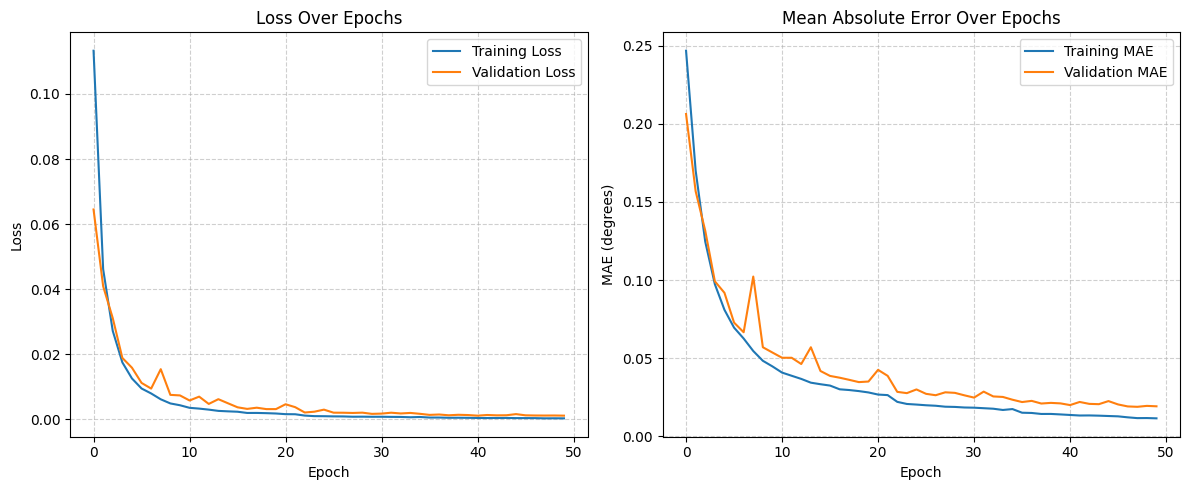

32/32 [==============================] - 0s 7ms/step
Error Analysis:
Mean Absolute Error: 7.30°
Median Absolute Error: 5.11°
Standard Deviation of Error: 9.52°
Min Error: 0.03°
Max Error: 139.31°
Error < 15°: 90.50%
Error < 30°: 97.60%


/tmp/ipykernel_95768/2505992699.py:141: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_by_bin, labels=[f"{int(a)}" for a in angle_bins_centers])
/tmp/ipykernel_95768/2505992699.py:159: RuntimeWarning: invalid value encountered in divide
  confusion_norm = confusion / row_sums


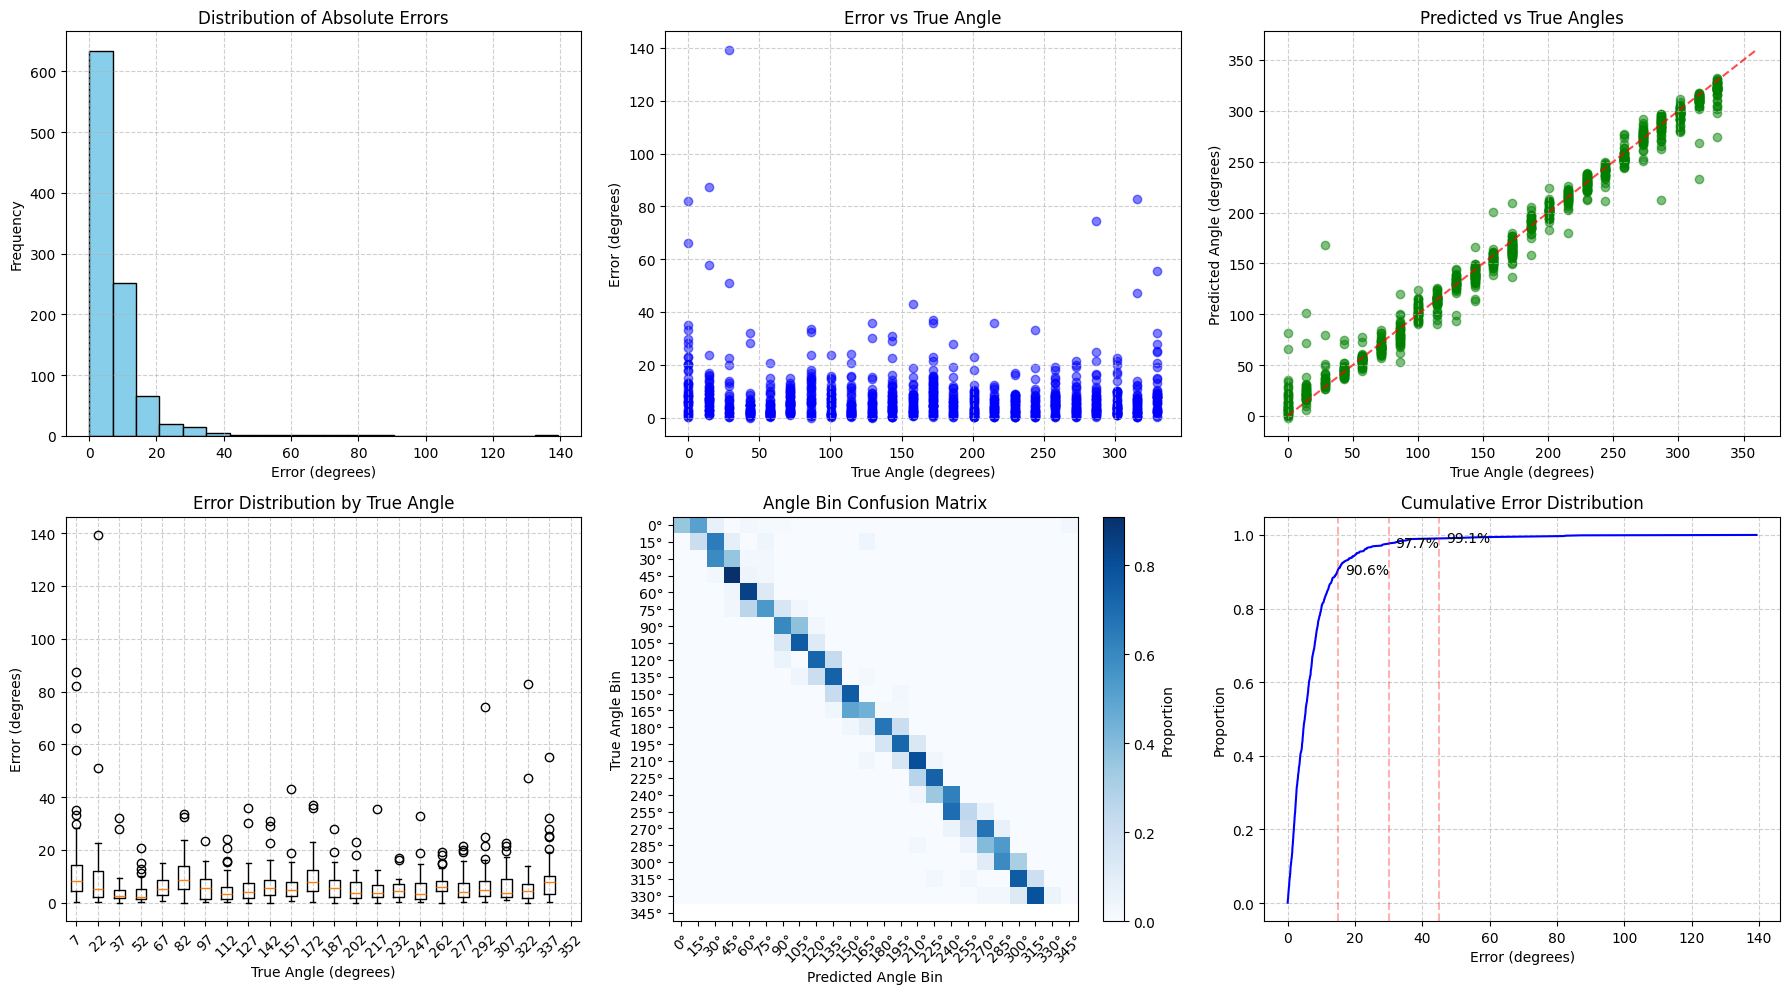

Overall mean error: 7.30 degrees


In [ ]:
plot_training_history(history)
# Run error analysis on 1000 samples
error_stats = perform_error_analysis(model, x_test, num_samples=1000)

# The returned dictionary contains all raw data for further analysis if needed
print(f"Overall mean error: {error_stats['mean_error']:.2f} degrees")

In [21]:
perform_detailed_analysis(error_stats)

Mean error near 0/360 boundary: 28.14
Mean error for 0°-90°: 9.01
Mean error for 90°-180°: 6.82
Mean error for 180°-270°: 6.60
Mean error for 270°-360°: 12.41
Overall prediction bias: -2.98°


157/157 [==============================] - 14s 85ms/step
Error Analysis:
Mean Absolute Error: 9.22
Median Absolute Error: 5.57
Standard Deviation of Error: 16.10
Min Error: 0.00
Max Error: 177.15
Error < 15°: 87.50%
Error < 30°: 96.46%


/var/folders/4t/2y_lbh010077fp4ml0fss6wc0000gn/T/ipykernel_51200/675576848.py:148: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(error_by_bin, labels=[f"{int(a)}" for a in angle_bins_centers])


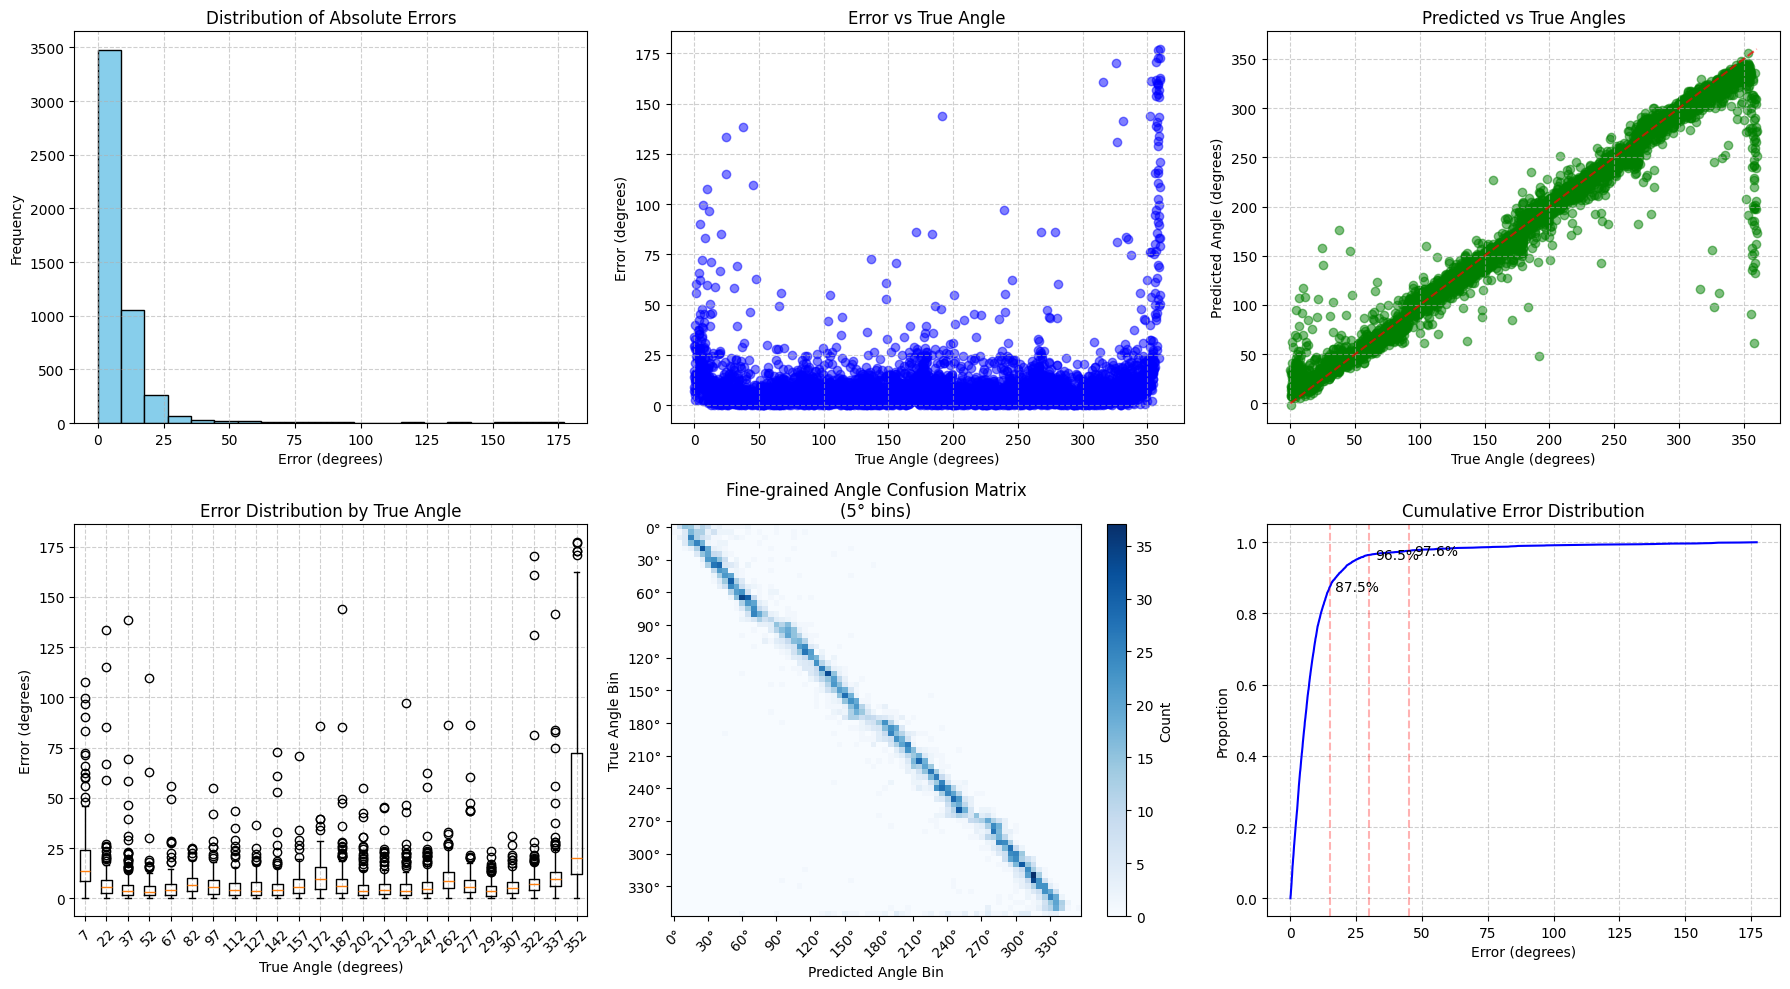

In [30]:
model = tf.keras.models.load_model('siamese_rotation_model_10032025.h5')
_, _, x_test, _ = load_data()
error_stats = perform_error_analysis(model, x_test, num_samples=5000)


In [33]:
continuous_angles = np.random.uniform(0, 360, size=1000)
continuous_angles

array([ 90.9569516 , 242.68958022, 245.12323722, 275.15195298,
       253.55580082,  90.41755393, 244.38390559, 250.80476746,
       113.22801443, 305.31286044,   1.2568134 , 291.62951084,
       205.88565189,  19.29585415, 117.16493315, 257.9500493 ,
        56.17208527, 154.70528106, 299.15184037, 282.74455192,
       324.93054482, 217.21023006,  14.7306668 , 194.00403011,
       129.7419037 , 316.61798523, 321.24972867,  21.57032962,
       164.47454896,  69.7295006 , 255.23136667,  18.78514459,
       169.09197857, 170.65549682, 339.96896554, 159.34088647,
       322.93593   , 280.07877226,  12.63023995,  93.58899756,
       310.31025704,  45.1127323 , 211.61186946,  44.30417938,
       190.86599749, 261.71574217,  28.07464203, 178.84116187,
       279.56670482, 244.84374315,  75.75774151, 176.08857717,
       197.94075477,  13.91031852, 157.25401737, 144.15060579,
       151.46429415,  98.55393432, 291.02116842, 190.14997357,
       353.62228907,  99.12915462,  15.56508816, 136.50

1/1 [==============================] - 1s 526ms/step


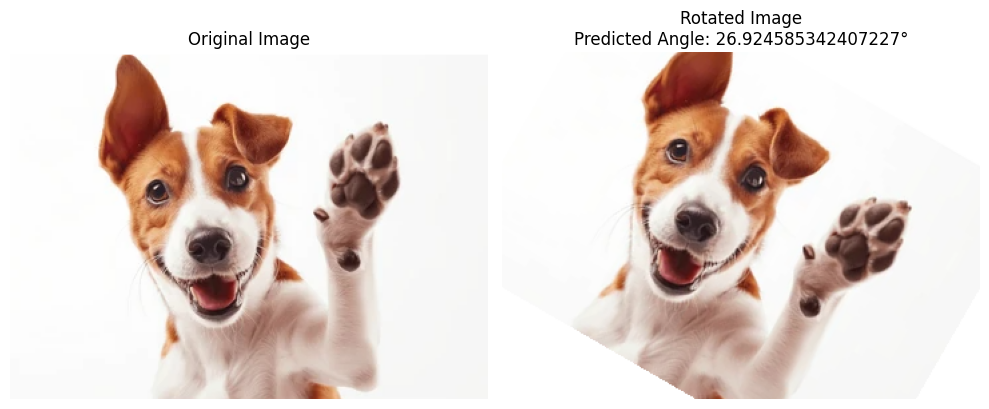

True rotation angle: 30
Predicted rotation angle: 26.924585342407227
Error: 3.0754146575927734


In [11]:
from PIL import Image
model = tf.keras.models.load_model('siamese_rotation_model_10032025.h5')
# Test on a single pair
# idx = np.random.randint(0, len(x_test))
angle = 30

# im_path='/home/hamed/code/hamed/rotation_project/dog2.png'
im_path='/Users/roshanakzakizadeh/Projects/Veritone_rotation_exercise/test_images/dog2.png'
original_image = np.array(Image.open(im_path).convert('RGB'))
# original_image = x_test[idx]

rotated_image = rotate(original_image, -angle, reshape=False, cval=255.0)
# Image.fromarray(rotated_image).save('/home/hamed/code/hamed/rotation_project/dog2_rotated.png')

# get the prediction and visualize 
predicted_angle = visualize_single_prediction(model, original_image, rotated_image)

print(f"True rotation angle: {angle}")
print(f"Predicted rotation angle: {predicted_angle}")
print(f"Error: {min(abs(angle - predicted_angle), 360 - abs(angle - predicted_angle))}")

1/1 [==============================] - 0s 36ms/step


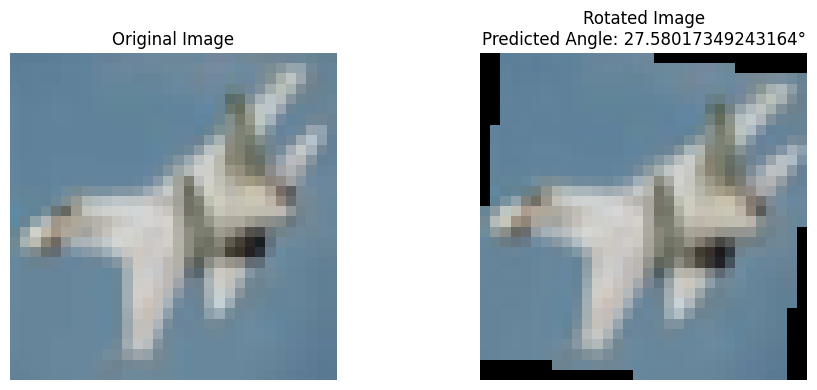

True rotation angle: 7
Predicted rotation angle: 27.58017349243164
Error: 20.58017349243164


In [17]:
image_idx = 10
angle = 7
(_, _), (x_test, _) = cifar10.load_data()
x_test = x_test.astype('float32')

# Get the specified image
original_image = x_test[image_idx]

# Create rotated image
rotated_image = rotate(original_image, -angle, reshape=False)

# Get prediction and visualize
predicted_angle = visualize_single_prediction(model, original_image, rotated_image)

# Print results
print(f"True rotation angle: {angle}")
print(f"Predicted rotation angle: {predicted_angle}")
print(f"Error: {min(abs(angle - predicted_angle), 360 - abs(angle - predicted_angle))}")

1/1 [==============================] - 0s 485ms/step


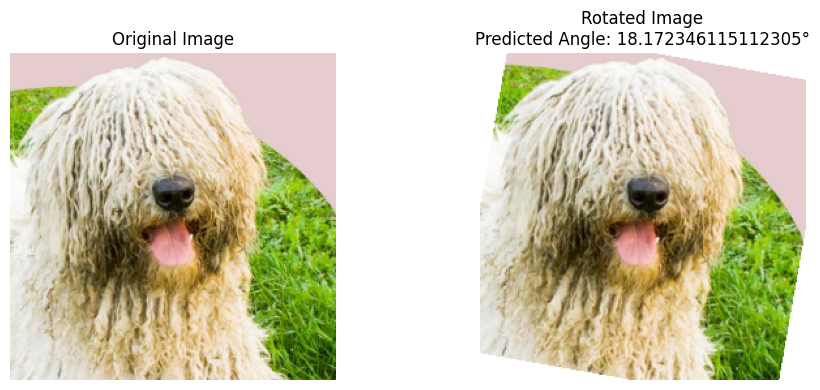

In [27]:
from PIL import Image
model = tf.keras.models.load_model('siamese_rotation_model_10032025.h5')

im_path='/home/hamed/code/hamed/rotation_project/test_images/dog.png'
im_path_rotated='/home/hamed/code/hamed/rotation_project/test_images/dog_rotated.png'
original_image = np.array(Image.open(im_path).convert('RGB'))
rotated_image = np.array(Image.open(im_path_rotated).convert('RGB'))

# get the prediction and visualize 
predicted_angle = visualize_single_prediction(model, original_image, rotated_image)


In [16]:
angle = 10

im_path='/home/hamed/code/hamed/rotation_project/dog.png'
original_image = np.array(Image.open(im_path).convert('RGB'))
# original_image = x_test[idx]

rotated_image = rotate(original_image, -angle, reshape=False, cval=255.0)
Image.fromarray(rotated_image).save('/home/hamed/code/hamed/rotation_project/dog_rotated.png')

In [ ]:
import tensorflow as tf

def inspect_model():
    print("Loading model...")
    model = tf.keras.models.load_model('saved_model')
    
    print("\nModel Summary:")
    model.summary()
    
    print("\nDetailed Layer Information:")
    for i, layer in enumerate(model.layers):
        print(f"\nLayer {i}:")
        print(f"  Name: {layer.name}")
        print(f"  Type: {type(layer).__name__}")
        print(f"  Input shape: {layer.input_shape}")
        print(f"  Output shape: {layer.output_shape}")
        
        # If it's a functional model or sequential, print its layers
        if hasattr(layer, 'layers'):
            print("  Sub-layers:")
            for j, sublayer in enumerate(layer.layers):
                print(f"    {j}: {sublayer.name} ({type(sublayer).__name__})")

if __name__ == "__main__":
    inspect_model()

In [ ]:
import numpy as np
from sklearn.manifold import TSNE
from tensorflow.keras.datasets import cifar10
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy.ndimage import rotate
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras import Model

def analyze_rotated_clusters():
    # Load data and model
    print("Loading CIFAR-10 data...")
    (_, _), (x_test, y_test) = cifar10.load_data()
    x_test = x_test.astype('float32')
    
    print("Loading saved model...")
    model = tf.keras.models.load_model('saved_model')
    
    # Create feature extraction model
    print("Creating feature extraction model...")
    base_model = model.get_layer('mobilenetv2_1.00_96')
    feature_model = Model(inputs=base_model.input, outputs=base_model.output)
    
    # Generate rotated versions and extract features
    angles = [0, 45, 90, 135, 180]  # Example angles
    n_samples = 100  # Number of images per class to use
    
    features_list = []
    labels_list = []
    angles_list = []
    
    print(f"Processing {n_samples} images at {len(angles)} different angles...")
    for idx in range(n_samples):
        if idx % 10 == 0:  # Progress update every 10 images
            print(f"Processing image {idx}/{n_samples}")
        
        img = x_test[idx]
        label = y_test[idx][0]
        
        for angle in angles:
            # Rotate and preprocess image
            rotated = rotate(img, -angle, reshape=False)
            processed = tf.image.resize_with_pad(rotated, 96, 96)
            processed = preprocess_input(processed)
            processed = np.expand_dims(processed, axis=0)
            
            # Extract features
            features = feature_model.predict(processed, verbose=0)
            features = features.reshape(-1)  # Flatten features
            
            features_list.append(features)
            labels_list.append(label)
            angles_list.append(angle)
    
    # Convert to numpy arrays
    print("Converting to numpy arrays...")
    features_array = np.array(features_list)
    labels_array = np.array(labels_list)
    angles_array = np.array(angles_list)
    
    # Apply t-SNE
    print("Computing t-SNE...")
    tsne = TSNE(n_components=2, random_state=42)
    features_2d = tsne.fit_transform(features_array)
    
    return features_2d, labels_array, angles_array

# CIFAR-10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
               'dog', 'frog', 'horse', 'ship', 'truck']

def plot_with_annotations(features_2d, labels, angles):
    plt.figure(figsize=(20, 10))
    
    # Plot by class with labels
    plt.subplot(1, 2, 1)
    for i, class_name in enumerate(class_names):
        mask = labels == i
        plt.scatter(
            features_2d[mask, 0],
            features_2d[mask, 1],
            label=class_name,
            alpha=0.6
        )
    plt.title('t-SNE Clusters by Class')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot by angle
    plt.subplot(1, 2, 2)
    scatter = plt.scatter(
        features_2d[:, 0],
        features_2d[:, 1],
        c=angles,
        cmap='hsv',
        alpha=0.6
    )
    plt.title('t-SNE Clusters by Rotation Angle')
    plt.colorbar(scatter, label='Rotation Angle')
    
    plt.tight_layout()
    plt.savefig('tsne_visualization.png', bbox_inches='tight', dpi=300)
    plt.close()

if __name__ == "__main__":
    print("Starting t-SNE analysis...")
    try:
        features_2d, labels, angles = analyze_rotated_clusters()
        print("Plotting results...")
        plot_with_annotations(features_2d, labels, angles)
        print("Done! Check tsne_visualization.png for results.")
    except Exception as e:
        print(f"An error occurred: {str(e)}")

Starting t-SNE analysis...
Loading CIFAR-10 data...
Loading saved model...
Creating feature extraction model...
Processing 100 images at 5 different angles...
Processing image 0/100
Processing image 10/100
Processing image 20/100
Processing image 30/100
Processing image 40/100
Processing image 50/100
Processing image 60/100
Processing image 70/100
Processing image 80/100
Processing image 90/100
Converting to numpy arrays...
Computing t-SNE...
Plotting results...
Done! Check tsne_visualization.png for results.
